# Проект 2

In [1]:
# импорт библиотек

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy.stats import norm, shapiro, chi2_contingency
from tqdm.auto import tqdm

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## 1. A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.1 Предварительная проверка данных 

Есть файлы с данными

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента.

In [2]:
# Загружаем, делаем предпроверку

url_base = 'https://getfile.dokpub.com/yandex/get/'

url_groups = 'https://disk.yandex.ru/d/dEBxbwDgszbA_Q'
groups = pd.read_csv(url_base + url_groups, sep=';')

url_groups_add = 'https://disk.yandex.ru/d/2Zz0cjwmkXoijQ'
groups_add = pd.read_csv(url_base + url_groups_add, sep=',')

url_active_studs = 'https://disk.yandex.ru/d/TLDaPvKd8VbPmg'
active_studs = pd.read_csv(url_base + url_active_studs, sep=';')

url_checks = 'https://disk.yandex.ru/d/adhGJ2OqlyB3yg'
checks = pd.read_csv(url_base + url_checks, sep=';')

In [3]:
groups[:2]

,id,grp
0,1489,B
1,1627,A


In [4]:
groups_add[:2]

,id,grp
0,5694584,B
1,5694830,B


In [5]:
active_studs[:2]

,student_id
0,581585
1,5723133


In [6]:
checks[:2]

,student_id,rev
0,1627,990.0
1,3185,690.0


In [7]:
groups.info(), groups_add.info(), active_studs.info(), checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dty

(None, None, None, None)

In [8]:
# Приводим в соотвествие название колонок в датафреймах

active_studs = active_studs.rename(columns={'student_id': 'id'})
checks = checks.rename(columns={'student_id': 'id'})

In [9]:
# Сравним размер датафреймоф с кол-вом уникальных  id 

groups.shape, groups_add.shape, active_studs.shape, checks.shape

((74484, 2), (92, 2), (8341, 1), (541, 2))

In [10]:
groups.id.nunique(), groups_add.id.nunique(), active_studs.id.nunique(), checks.id.nunique()

(74484, 92, 8341, 541)

Внутри датафреймов нет пропусков и нет дублей

In [11]:
# Объединяем 2 датафрейма - основной с инфо по принадлежности пользователей к группам и дополнительный
groups_all = groups.merge(groups_add, how='outer').drop_duplicates()
groups_all.shape

(74576, 2)

In [12]:
# Проверим, что при мёрдже не потеряли данные 

groups.shape[0] + groups_add.shape[0] == groups_all.shape[0]

True

In [13]:
# Проверим, все ли оплатившие пользователи есть в списке активных

checks.shape[0] - checks[checks.id.isin(active_studs.id)].shape[0]

149

 Выявлено 149 пользователей, которые купили курс, но не были зафиксированны как посетившие сайт. Скорее всего произошла ошибка в записи или технический сбой. Добавляем этих пользователей в список активных

In [14]:
active_studs_all = active_studs.merge(checks, how='outer').drop_duplicates().drop(['rev'], axis=1)

In [15]:
active_studs_all.shape[0] - active_studs.shape[0]

149

In [16]:
# Данные по активным пользователям добавлены, переходим к объединению фреймов. 
# Промаркеруем активных и объединим инфо по ним с общим списком пользователей

active_studs_all['is_active'] = 1

In [17]:
# Начнем с мерджа фреймов всех пользователей с активными 

users = groups_all.merge(active_studs_all, how='left', on='id').fillna(0)

In [18]:
# Добавляем инфо по оплатам

full_data = users.merge(checks, how='left', on='id').fillna(0)

In [19]:
full_data.head()

,id,grp,is_active,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


### 1.2 Выбор метрик

А/В тест был направлен на проверку новой механики оплаты, значит в первую очередь интересна конверсия, плюс посмотрим на средние чеки. Метрики которые будем смотреть:

* CR

* ARPU (Average Revenue Per User ) - средний платеж на всех пользователей (в нашем случае активных в дни эесперимента)

* ARPPU ( Average Revenue Per Paying User ) - средний платеж на всех платящих пользователей

Для выбора метода исследуем данные. 

Проверяем распределение пользователей по группам (в таблице выше и так видно, что распределение неравномерно, тем не менее)

In [20]:
# распределение пользователей в группах в общем

percent_ab_total = round(full_data.grp.value_counts(normalize=True).mul(100), 3)
percent_ab_total

B    80.298
A    19.702
Name: grp, dtype: float64

In [21]:
# распределение активных пользователей в группах 

percent_ab_active = round(full_data.query('is_active == 1.0').grp.value_counts(normalize=True).mul(100), 3)
percent_ab_active

B    81.543
A    18.457
Name: grp, dtype: float64

In [22]:
# распределение платящих пользователей в группах 

percent_ab_paid = round(full_data.query('rev > 0.0').grp.value_counts(normalize=True).mul(100), 3)
percent_ab_paid

B    80.222
A    19.778
Name: grp, dtype: float64

Распределение неравномерное. В контрольной группе в 4 раза больше пользователей.

Исследуем распределение денег (покупок)

In [23]:
active_A = full_data.query('grp == "A" & is_active == 1.0')
active_B = full_data.query('grp == "B" & is_active == 1.0')

paid_A = full_data.query('grp == "A" & is_active == 1.0 & rev >0')
paid_B = full_data.query('grp == "B" & is_active == 1.0 & rev >0')

<AxesSubplot:>

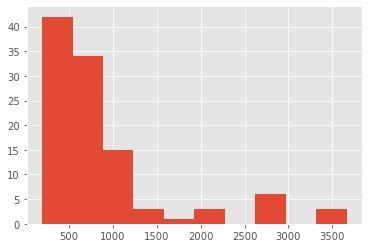

In [24]:
paid_A.rev.hist()

<AxesSubplot:>

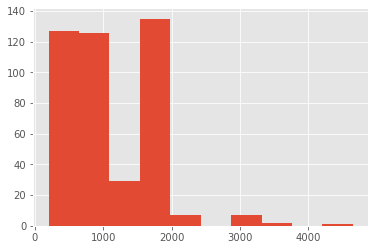

In [25]:
paid_B.rev.hist()

In [26]:
# Дополнительно проверяем нормальность распределение тестом Шапиро-Уилка
# при p-value > 0.05 - распределение нормальное

shapiro(paid_A.rev), shapiro(paid_B.rev)

(ShapiroResult(statistic=0.7196124196052551, pvalue=5.321687643507211e-13),
 ShapiroResult(statistic=0.8672363758087158, pvalue=8.947892893418603e-19))

Видим, что данные распределены ненормально и неравномерно. Подробнее посмотрим на "всплеск" около отметки 2000. 
После чего исследуем выбросы

In [27]:
paid_B.groupby('rev', as_index=False).agg({'id': 'count'}).sort_values('id', ascending=False).head()

,rev,id
22,1900.0000,97
1,290.0000,63
8,690.0000,59
0,199.0000,39
23,1900.0001,36


Имеем "всплеск" покупок на чек 1900 - 97, плюс на 1900,0001 - 36 чеков. 

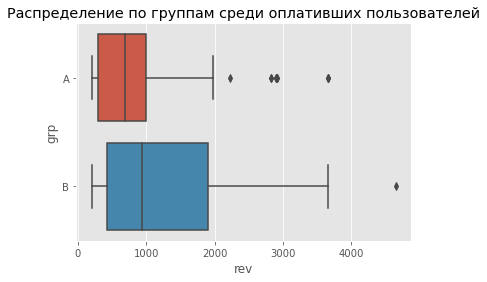

In [28]:
sns.boxplot(x="rev", y="grp", data=full_data.query(
    'rev>0 & is_active==1.0'))
plt.title('Распределение по группам среди оплативших пользователей')
plt.show()

In [29]:
print('Выбросы по группам:\n А -', len(active_A.query('rev > 2100')), ' \n Б -', len(active_B.query('rev > 4000')))

Выбросы по группам:
 А - 10  
 Б - 1


В выборках есть выбросы

In [30]:
# Описательные характеристики прибыли от группы A

paid_A.rev.describe()

count     107.000000
mean      860.710280
std       815.893445
min       199.000000
25%       290.000000
50%       690.000000
75%       990.000000
max      3660.000000
Name: rev, dtype: float64

In [31]:
# Описательные характеристики прибыли от группы B

paid_B.rev.describe()

count     434.000000
mean     1108.824893
std       741.834304
min       199.000000
25%       420.750000
50%       935.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [32]:
metric_df = pd.DataFrame(
    columns=['total_users', 'active_users', 'paying_users', 'money', 'ARPU', 'ARPPU', 'cr'], index=['A', 'B']
)

In [33]:
# Рассчитываем метрики 

metric_df['total_users'] = full_data.grp.value_counts()
metric_df['active_users'] = full_data.query('is_active == 1.0').grp.value_counts()
metric_df['paying_users'] = full_data.query('rev > 0.0').grp.value_counts()

metric_df['money'] = full_data.groupby('grp').rev.sum()
metric_df['ARPU'] = metric_df['money'] / metric_df['active_users']
metric_df['ARPPU'] = metric_df['money'] / metric_df['paying_users']

metric_df['cr'] = (metric_df['paying_users'] / metric_df['active_users']) * 100

In [34]:
metric_df

,total_users,active_users,paying_users,money,ARPU,ARPPU,cr
A,14693,1567,107,92096.0000,58.772176,860.710280,6.828334
B,59883,6923,434,481230.0036,69.511773,1108.824893,6.268959


### 1.3 Анализ конверсии

Итак, А – контрольная группа, B – целевая.

Цель эксперимента с новой механикой оплат понять, влияет ли она на конверсию в покупку (новая механика проще, меньше пользователей отваливается на этапе оплаты) и приведет ли к росту дохода.

Предварительные выводы по метрикам CR, ARPU, ARPPU согласно графикам и описательной характеристике:
* CR в целевой группе снизился, что уже плохо, тк новой механикой его планировалось повысить. 
* ARPU и ARPPU в группе В выше, хотя наш эксперимент не был направлен на увеличение средних чеков. 

На данном этапе можно говорить о негативном результате в плане показателей конверсии и неожиданном результате по части средних чеков. Не стоит упускать из вида повышение спроса на ценник 1900, причиной которого может быть другой эксперимент  - какое-либо промо на данный чек, кэшбэк/бонусы/и тд. Дополнительным подтверждением замечания можно отметить рост arpu и arppu. Требует уточнения - одновременное проведение двух экспериментов недопустимо. Или причиной может быть ошибка при сборе данных.


**Вернемся к CR.** Проанализируем конверсию методом хи-квадрат
Предварительно по расчетной таблице метрик можно судить о снижении конверсии в покупку у тестовой группы. Проанализируем стат значимость этого наблюдения.

Формируем гипотезы: 

Н0: "Конверсии в группах А и В не различаются"

Н1 : "Конверсия в группе В снизилась"

In [35]:
# требуется 2 бинарных еденицы, в частности отметка - совершил/не совершил оплату. Добавим столбец

full_data_cr = full_data.query('is_active == 1.0')
full_data_cr['paid'] = full_data_cr.rev > 0

In [36]:
full_data_cr[:2]

,id,grp,is_active,rev,paid
1,1627,A,1.0,990.0,True
10,2085,B,1.0,0.0,False


In [37]:
df_chi2 = pd.crosstab(full_data_cr.grp, full_data_cr.paid)
df_chi2

paid,False,True
grp,,
A,1460,107
B,6489,434


In [38]:
chi2, prob, df, expected = chi2_contingency(df_chi2)

output = "test Statistics: {}\ndegrees of freedom: {}\np-value: {}\n"

print(output.format(chi2, df, prob))

print(expected)

test Statistics: 0.579666003588264
degrees of freedom: 1
p-value: 0.4464432666411111

[[1467.14758539   99.85241461]
 [6481.85241461  441.14758539]]


 p_value > 0.05 а значит нет оснований отклонить нулевую гипотезу, принимаем что, конверсии не отличаются.

### 1.4 Анализ средних чеков

Здесь применим бутстрап для определения статистической значимости изменений, от применения t-тест или критерия Манна-Уитни отказываемся (ненормальное распределение и сложность интерпритаци результатов), применим бутстрап-метод для определения статистической значимости.

In [39]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    bootstrap_conf_level=0.95,  # уровень значимости
    statistic = np.mean
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        boot_data.append(statistic(samples_1 - samples_2))
              
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

**Проверка ARPU**

Формулируем гипотезы:

Н0 : "Изменение механики оплаты не влияет на средний чек" 

Н1 : "Изменение механики оплаты повлечет рост среднего чека"

  0%|          | 0/1000 [00:00<?, ?it/s]

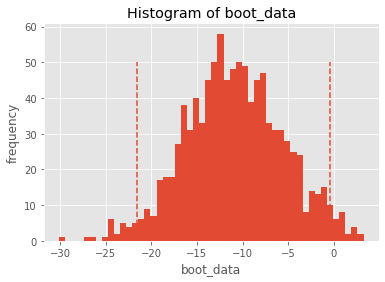

Значение p_value: 0.0419430099436854


In [40]:
# применение бутстрап к данным по активным пользователям

booted_data_rev = get_bootstrap(active_A.rev, active_B.rev)

print(f'Значение p_value: {booted_data_rev["p_value"]}')

In [41]:
booted_data_rev['ci']

,0
0.025,-21.525080
0.975,-0.399575


Методом Bootstrap (срез по активным пользователям) получили p_value < 0.05 и '0' не входящий в доверительный интервал. Из этого следует, что есть основание отвергать нулевую гипотезу H0 и принять альтернативную, изменение механики оплаты  повлияет на средний чек.

**Проверка ARPPU**

Гипотезы:

Н0 : "Изменение механики оплаты не влияет на средний чек платящих пользователей" 

Н1 : "Изменение механики оплаты повлечет рост arppu"

  0%|          | 0/1000 [00:00<?, ?it/s]

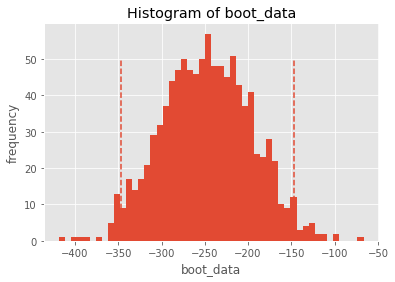

Значение p_value: 1.6042955255864301e-06


In [42]:
# применение бутстрап к данным по платящим пользователям

booted_data_rev_1 = get_bootstrap(paid_A.rev, paid_B.rev)

print(f'Значение p_value: {booted_data_rev_1["p_value"]}')

In [43]:
booted_data_rev_1['ci']

,0
0.025,-346.499260
0.975,-147.474143


Методом Bootstrap (срез по платящим пользователям) получили p_value < 0.05 и '0' не входящий в доверительный интервал. Как и в предыдущем случае, здесь есть основание отвергнуть нулевую гипотезу и принять альтернативную, принять, что изменение механики повлечет рост среднего чека в разрезе платящих пользователей.

Делаем вывод о стат значимости роста arpu и arppu в целевой группе.

### 1.5  Итоги 

 * Проверка статистической значимости изменения конверсии дала отрицательный результат, разницы CR в группах нет
 
 * Bootstrap показал наличие статистически значимых различий arpu и arppu в исследуемых группах, в целевой группе показатели выше на 29% и 36% соответственно. Есть основание считать результаты статзначимы. 

* Увеличение дохода в тестовой группе прошло неравномерно относительно контрольной. Был выявлен явный всплеск покупок (ценник 1900). Что это: результат другого одновременно проводимого эксперимента или ошибка при сборе данных?

* В рамках заявленного эксперимента очевидно ожидание роста cr (цель - меньше пользователей "отваливается" на этапе оплаты), вместо этого получили прирост arpu и arppu

### 1.6 Выводы

Оставить базовую (старую) механику оплаты вплоть до выяснения:

1. Был/не был одновременно запущен другой эксперимент;
2. Причины всплеска продаж ценника 1900 в тестовой (В) группе 

Если ответы по пунктам 1 и 2 отрицательные  - не было второго эксперимента и нет ошибок - выкатывать новую механику оплат на всех пользователей уместно только после обсуждения результата со стейкхолдерами. Тк несмотря на рост средних чеков, основная задача - повысить конверсию - не решена. Оптимальным, на мой взгляд, здесь будет повторить эксперимент.

Также повтор A/B тестирования потребуется, если окажется, что одновременно проводили другое тестирование.

Такми образом А/В тест механики нужно повторить. Плюс обратить внимание на: 
* спрос на ценник 1900;
* распределение пользователей по группам.

___________________________________________________________________________________

## 3. Python

### 3.1 Функция для автоматической подгрузки информации из дополнительного файла groups_add.csv  и  перерасчета метрик

In [44]:
url_base = 'https://getfile.dokpub.com/yandex/get/'
link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'   # на входе подается ссылка на новый groups_add файл
groups_add_path = url_base + link

In [45]:
def add_new_data(groups_add_path, groups, active_studs, checks):
    """Подгружает данные из доп файла и пересчитывает метрики"""
    
    # Скачивание данных с Яндекс.Диск 
    groups_add = pd.read_csv(groups_add_path, sep=',')
    
    # Объединение в общий DataFrame
    groups_all = pd.concat([groups, groups_add.rename(columns={groups_add.columns[0]: 'id',
                                                               groups_add.columns[1]: 'grp'})])
    # Обновление индексов
    groups_all = groups_all.reset_index(drop=True)
    
    # Приведение колонок к одинаковому названию
    active_studs.rename(columns={'student_id': 'id'}, inplace=True)
    checks.rename(columns={'student_id': 'id'}, inplace=True)
    
    active_studs['is_active'] = 1
    
    # Полный датафрейм
    df = groups_all.merge(active_studs, how='left', on='id').merge(checks, how='left', on='id').fillna(0)

    metrics_df = pd.DataFrame(
        columns=['total_users', 'active_users', 'paying_users', 'money', 'ARPU', 'ARPPU', 'cr'], index=['A', 'B']
    )
    
    metrics_df['total_users'] = df.grp.value_counts()
    metrics_df['active_users'] = df.query('is_active == 1').grp.value_counts()
    metrics_df['paying_users'] = df.query('rev > 0').grp.value_counts()
    metrics_df['money'] = df.groupby('grp').rev.sum()
    metrics_df['ARPU'] = metrics_df['money'] / metrics_df['active_users']
    metrics_df['ARPPU'] = metrics_df['money'] / metrics_df['paying_users']
    metrics_df['cr'] = (metrics_df['paying_users'] / metrics_df['active_users']) * 100
    
    return metrics_df


print(add_new_data.__doc__)

Подгружает данные из доп файла и пересчитывает метрики


In [46]:
metrics_df = add_new_data(groups_add_path, groups, active_studs, checks)

In [47]:
metrics_df

,total_users,active_users,paying_users,money,ARPU,ARPPU,cr
A,14693,1538,107,92096.0000,59.880364,860.710280,6.957087
B,59883,6803,434,481230.0036,70.737910,1108.824893,6.379538


### 3.2 Функция, которая строит графики по полученным метрикам

In [48]:
def get_graphs(metrics_df):
    """Построение графиков по полученным метриакам"""
    fig, axes = plt.subplots(3, 1, figsize=(20, 10))
    sns.barplot(ax=axes[0], data=metrics_df, x=metrics_df['ARPU'], y=metrics_df.index.values)
    sns.barplot(ax=axes[1], data=metrics_df, x=metrics_df['ARPPU'], y=metrics_df.index.values)
    
    sns.barplot(ax=axes[2], data=metrics_df, x=metrics_df['cr'], y=metrics_df.index.values)

    
print(get_graphs.__doc__)

Построение графиков по полученным метриакам


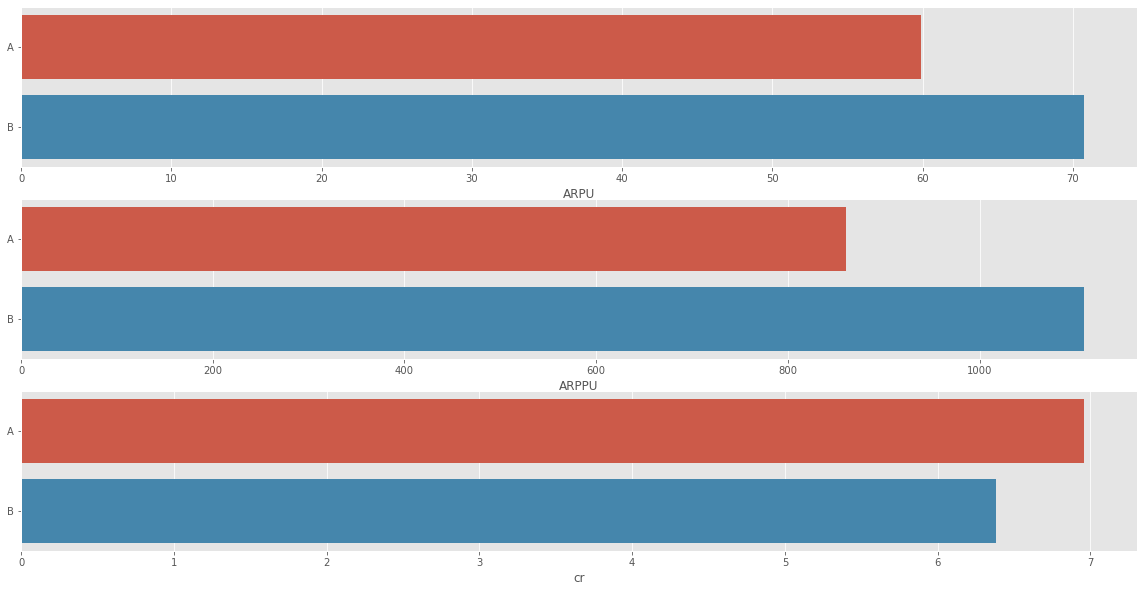

In [49]:
get_graphs(metrics_df)

______________________________________________________________________________________________________________________